<a href="https://colab.research.google.com/github/Kzis/ml-programming-python/blob/master/Homework/%E0%B8%AA%E0%B9%88%E0%B8%87%E0%B8%81%E0%B8%B2%E0%B8%A3%E0%B8%9A%E0%B9%89%E0%B8%B2%E0%B8%99%E0%B8%A3%E0%B8%AD%E0%B8%9A%E0%B8%97%E0%B8%B5%E0%B9%881/Project1-CTR/CTR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# install kaggle เพื่อใช้ api ของ kaggle
!pip install kaggle


In [0]:
# import file เข้า workspace ของ colab
# import file kaggle.json เป็น api token สำหรับการใช้งาน

from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"driftkao","key":"abaf4b93b1aee12aca93fd3d1809cc25"}'}

In [0]:
# list file ที่อยู่ directory ปัจจุบันมาแสดง

!ls -a

.  ..  .config	kaggle.json  sample_data


In [0]:
# สร้าง Folder kaggle ที่ directory ปัจจุบัน

! mkdir ~/.kaggle


In [0]:
# copy file  kaggle ไปที่ folder kaggle

! cp kaggle.json ~/.kaggle/

In [0]:
# chmod 600 file kaggle.json เพื่อให้ owner สามารถ read และ write

! chmod 600 ~/.kaggle/kaggle.json

In [0]:
# download dataset จาก kaggle ผ่าน api

!kaggle competitions download -c avazu-ctr-prediction

 99% 1.03G/1.04G [00:11<00:00, 114MB/s]
100% 1.04G/1.04G [00:11<00:00, 97.9MB/s]
 83% 98.0M/118M [00:01<00:00, 65.3MB/s]
100% 118M/118M [00:01<00:00, 93.9MB/s] 
 54% 18.0M/33.2M [00:00<00:00, 50.2MB/s]
100% 33.2M/33.2M [00:00<00:00, 111MB/s] 


In [0]:
# Extract zipfile test data

!gunzip test.gz

In [0]:
# Extract zipfile train data

!gunzip train.gz

In [0]:
# import lib

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve ,auc ,roc_auc_score


In [0]:
#อ่านข้อมูลจาก directory ของ google clab ผมทำการอ่านมา 500k rec และทำการดูข้อมูลว่ามีอะไรบ้าง

df = pd.read_csv('train', nrows=5e5)
df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,ddd2926e,44956a24,1,2,15706,320,50,1722,0,35,-1,79
1,1.000017e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,96809ac8,711ee120,1,0,15704,320,50,1722,0,35,100084,79
2,1.000037e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,b3cf8def,8a4875bd,1,0,15704,320,50,1722,0,35,100084,79
3,1.000064e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8275b8f,6332421a,1,0,15706,320,50,1722,0,35,100084,79
4,1.000068e+19,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,07d7df22,a99f214a,9644d0bf,779d90c2,1,0,18993,320,50,2161,0,35,-1,157


In [0]:
df.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'],
      dtype='object')

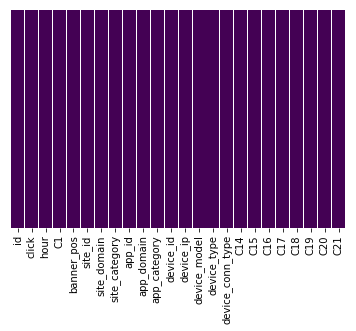

In [0]:
# ตรวจสอบข้อมูลแต่ละ column ว่ามีค่า null - พบว่าไม่มี

sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [0]:
# ดูข้อมูลว่า device_type มีกี่ชนิด แต่ละชนิดมีจำนวนเท่าไหร่

df['device_type'].value_counts()

1    473317
0     15617
4     10300
5       766
Name: device_type, dtype: int64

In [0]:
# ดูข้อมูลว่า device_conn_type มีกี่ชนิด แต่ละชนิดมีจำนวนเท่าไหร่

df['device_conn_type'].value_counts()

0    447909
2     45337
3      6313
5       441
Name: device_conn_type, dtype: int64

In [0]:
# ดูข้อมูลว่า device_conn_type มีกี่ชนิด แต่ละชนิดมีจำนวนเท่าไหร่

df['app_category'].value_counts()

07d7df22    349947
0f2161f8    103610
f95efa07     14990
cef3e649     13396
8ded1f7a     12993
d1327cf5      1827
75d80bbe       872
fc6fa53d       824
4ce2e9fc       659
09481d60       220
dc97ec06       185
879c24eb       159
a3c42688       126
0f9a328c        89
a86a3e89        39
4681bb9d        31
7113d72a        13
a7fd01ec        11
8df2e842         8
2281a340         1
Name: app_category, dtype: int64

In [0]:
# ทำการสร้าง dummies ให้กับ column ทั้ง 3

device_type = pd.get_dummies(df.device_type, drop_first=True)
device_conn_type = pd.get_dummies(df.device_conn_type, drop_first=True)
app_category = pd.get_dummies(df.app_category, drop_first=True)

In [0]:
# ทำการตัดข้อมูลมาเฉพาะ columns ของ banner_pos และ categorical variables

X = df[['banner_pos', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']]
X = pd.concat([X, device_type, device_conn_type, app_category], axis=1)

y = df['click']

In [0]:
# ทำการแบ่งข้อมูล train 0.7 และ test 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=112)

In [0]:
# Train data

logreg = LogisticRegression(solver='liblinear',
                            max_iter=1000,
                            verbose=100)
logreg.fit(X_train, y_train)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001,
                   verbose=100, warm_start=False)

In [0]:
# Predict

y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91    125392
           1       0.33      0.01      0.01     24608

    accuracy                           0.83    150000
   macro avg       0.58      0.50      0.46    150000
weighted avg       0.75      0.83      0.76    150000



# ผลลัพธ์ของโมเดล
Accuracy ค่อนข้างสูง คือ 0.83 แต่เมื่อพิจารณา precision, recall เพิ่มเติมพบว่า ผลของ class 1 มีค่าน้อยมาก เกิดจาก imbalance dataset ทำให้ accuracy ที่สูงนั้น มาจากของ class 0